# Pipeline Machine Learning Complet - Prévision météo (série temporelle)
## Réalisé par : 
- GASTLI Nassim
- SAHNOUN Bilel
MSc 2 - Data & IA - Fr - Mastering Data Life Cycle Project - Mme BENNAI Soufia

## Contexte
Ce notebook implémente un pipeline complet de Machine Learning, de la collecte de données jusqu’au déploiement, en respectant les phases demandées (collecte, préparation, features, stockage SQLite, archivage, EDA, entraînement, validation, API, monitoring).

## Problématique (série temporelle)
Prédire la **température horaire** à l’horizon **t + 1 heure** à partir des observations passées.


# Étape 1 - Choix du sujet (dataset)

## Sujet 
**Prévision de la température horaire** (régression) : prédire `temperature_2m(t+1)` à partir des observations à `t, t-1, t-2, ...`

## Source de données
**Open-Meteo Historical Weather API**
- Données publiques
- Accès gratuit
- Sans clé API
- Historique horaire

## Objectif de prédiction
- Variable cible : `temperature_2m`
- Horizon : `t+1` (une heure après)


In [215]:
from pathlib import Path
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


# Phase 0 - Initialisation & configuration

## Objectifs
- Créer l’arborescence du projet
- Définir les chemins de travail
- Centraliser les paramètres (ville, période, variables, etc.)

## Arborescence attendue
- `data/raw/`
- `data/processed/`
- `data/archive/`
- `models/`
- `reports/`


In [216]:
PROJECT_ROOT = Path(".").resolve()

DIR_DATA = PROJECT_ROOT / "data"
DIR_RAW = DIR_DATA / "raw"
DIR_PROCESSED = DIR_DATA / "processed"
DIR_ARCHIVE = DIR_DATA / "archive"
DIR_MODELS = PROJECT_ROOT / "models"
DIR_REPORTS = PROJECT_ROOT / "reports"

for d in [DIR_RAW, DIR_PROCESSED, DIR_ARCHIVE, DIR_MODELS, DIR_REPORTS]:
    d.mkdir(parents=True, exist_ok=True)

print(" -", DIR_RAW)
print(" -", DIR_PROCESSED)
print(" -", DIR_ARCHIVE)
print(" -", DIR_MODELS)
print(" -", DIR_REPORTS)


 - C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\raw
 - C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\processed
 - C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\archive
 - C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\models
 - C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\reports


In [217]:
CONFIG = {
    "source_name": "open_meteo_historical",
    "timezone": "Europe/Paris",

    # Localisation (modifiable)
    "city": "Paris",
    "latitude": 48.8566,
    "longitude": 2.3522,

    # Historique
    "history_days": 90,

    # Variables horaires à récupérer
    "hourly_vars": [
        "temperature_2m",
        "relative_humidity_2m",
        "precipitation",
        "pressure_msl",
        "wind_speed_10m",
        "cloud_cover",
    ],

    # Objectif ML
    "target_col": "temperature_2m",
    "horizon_steps": 1,  # t+1 (1 heure)

    # Base SQLite
    "db_path": str(DIR_DATA / "pipeline.db"),
}

end_date = datetime.now(timezone.utc).date()
start_date = (datetime.now(timezone.utc) - timedelta(days=CONFIG["history_days"])).date()
CONFIG["start_date"] = str(start_date)
CONFIG["end_date"] = str(end_date)

print("CONFIG :")
for k, v in CONFIG.items():
    print(f" - {k}: {v}")


CONFIG :
 - source_name: open_meteo_historical
 - timezone: Europe/Paris
 - city: Paris
 - latitude: 48.8566
 - longitude: 2.3522
 - history_days: 90
 - hourly_vars: ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 'wind_speed_10m', 'cloud_cover']
 - target_col: temperature_2m
 - horizon_steps: 1
 - db_path: C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\pipeline.db
 - start_date: 2025-11-15
 - end_date: 2026-02-13


# Phase 1 - Collecte et ingestion des données

## Objectifs
- Utiliser une **source publique** : Open-Meteo (API)
- Récupérer automatiquement une période suffisante (**90 jours** par défaut)
- Sauvegarder les données brutes dans `data/raw/` au format **JSON + CSV** avec **horodatage**
- Afficher un aperçu : `head()`, dimensions, types


In [218]:
# Phase 1 — 1) Requête 
import requests

BASE_URL = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": CONFIG["latitude"],
    "longitude": CONFIG["longitude"],
    "start_date": CONFIG["start_date"],
    "end_date": CONFIG["end_date"],
    "hourly": ",".join(CONFIG["hourly_vars"]),
    "timezone": CONFIG["timezone"],
}

print("- Source publique :", CONFIG["source_name"])
print("- Ville :", CONFIG["city"], "|", CONFIG["latitude"], CONFIG["longitude"])
print("- Période :", CONFIG["start_date"], "→", CONFIG["end_date"])
print("- Variables :", CONFIG["hourly_vars"])


- Source publique : open_meteo_historical
- Ville : Paris | 48.8566 2.3522
- Période : 2025-11-15 → 2026-02-13
- Variables : ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 'wind_speed_10m', 'cloud_cover']


In [219]:
# Phase 1 — 2) Téléchargement

response = requests.get(BASE_URL, params=params, timeout=60)
response.raise_for_status()

data_json = response.json()

print("Téléchargement OK")
print("Clés principales :", list(data_json.keys()))


Téléchargement OK
Clés principales : ['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'hourly_units', 'hourly']


In [220]:
# Phase 1 — 3) Sauvegarde brute (raw)

import json

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Fichiers horodatés
json_path = DIR_RAW / f"meteo_{CONFIG['city'].lower()}_hourly_{timestamp}.json"
csv_path  = DIR_RAW / f"meteo_{CONFIG['city'].lower()}_hourly_{timestamp}.csv"

# Sauvegarde JSON (brut)
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(data_json, f, ensure_ascii=False)

# Conversion en DataFrame puis CSV
df_raw = pd.DataFrame(data_json["hourly"])
df_raw["time"] = pd.to_datetime(df_raw["time"])

df_raw.to_csv(csv_path, index=False)

print("Données brutes sauvegardées :")
print(" - JSON :", json_path)
print(" - CSV  :", csv_path)
print("Shape df_raw :", df_raw.shape)


Données brutes sauvegardées :
 - JSON : C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\raw\meteo_paris_hourly_20260213_144038.json
 - CSV  : C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\raw\meteo_paris_hourly_20260213_144038.csv
Shape df_raw : (2184, 7)


In [221]:
# Phase 1 — 4) Aperçu (head, shape, dtypes)

display(df_raw.head(10))

print("\nDimensions (lignes, colonnes) :", df_raw.shape)

print("\nTypes des colonnes :")
print(df_raw.dtypes)


,time,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,wind_speed_10m,cloud_cover
0,2025-11-15 00:00:00,14.0,93,0.1,1005.7,10.8,100
1,2025-11-15 01:00:00,13.3,95,0.0,1006.4,10.1,100
2,2025-11-15 02:00:00,12.4,96,8.0,1006.6,6.7,100
3,2025-11-15 03:00:00,12.6,96,4.4,1006.4,6.1,100
4,2025-11-15 04:00:00,12.1,97,1.8,1006.7,9.7,99
5,2025-11-15 05:00:00,11.8,95,0.1,1006.6,7.3,95
6,2025-11-15 06:00:00,11.0,97,0.0,1006.7,3.9,87
7,2025-11-15 07:00:00,10.9,98,0.0,1007.3,6.5,100
8,2025-11-15 08:00:00,10.9,98,0.0,1007.4,6.0,95
9,2025-11-15 09:00:00,11.3,98,0.0,1007.9,7.1,100



Dimensions (lignes, colonnes) : (2184, 7)

Types des colonnes :
time                    datetime64[ns]
temperature_2m                 float64
relative_humidity_2m             int64
precipitation                  float64
pressure_msl                   float64
wind_speed_10m                 float64
cloud_cover                      int64
dtype: object


In [222]:
# Contrôle qualité

print("\nValeurs manquantes par colonne :")
print(df_raw.isna().sum())

print("\nDoublons :", df_raw.duplicated().sum())



Valeurs manquantes par colonne :
time                    0
temperature_2m          0
relative_humidity_2m    0
precipitation           0
pressure_msl            0
wind_speed_10m          0
cloud_cover             0
dtype: int64

Doublons : 0


# Phase 2 - Préparation des données et ingénierie des caractéristiques

## Objectif
Transformer les données brutes issues de la Phase 1 afin de :
- Nettoyer et fiabiliser la série temporelle
- Construire des variables explicatives pertinentes (features)
- Préparer un jeu de données exploitable pour la modélisation

## Contenu de cette phase
- Nettoyage des données (types, valeurs manquantes, doublons)
- Création d’au moins **12 features**, incluant :
  - Variables statistiques de base
  - Retards temporels (lags)
  - Moyennes mobiles
  - Variables cycliques (temps)
  - Indicateurs booléens
- Sauvegarde des données transformées dans `data/processed/`


In [223]:
# Phase 2 — 1) Nettoyage des données 

df = df_raw.copy()

# Tri chronologique
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time").reset_index(drop=True)

# Suppression des doublons temporels
df = df.drop_duplicates(subset=["time"])

# Conversion explicite des types numériques
numeric_cols = [c for c in df.columns if c != "time"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Interpolation temporelle : nécessite un DatetimeIndex
df = df.set_index("time")
df[numeric_cols] = df[numeric_cols].interpolate(method="time")

# (Optionnel mais conseillé) compléter les bords si NaN au début/fin
df[numeric_cols] = df[numeric_cols].ffill().bfill()

# Revenir à une colonne time
df = df.reset_index()

print("Valeurs manquantes restantes :", df.isna().sum().sum())
print("Shape :", df.shape)


Valeurs manquantes restantes : 0
Shape : (2184, 7)


In [224]:
# Phase 2 — 2) Variables temporelles

df["hour"] = df["time"].dt.hour
df["dayofweek"] = df["time"].dt.dayofweek
df["month"] = df["time"].dt.month

print("Variables temporelles créées : hour, dayofweek, month")


Variables temporelles créées : hour, dayofweek, month


In [225]:
# Phase 2 — 3) Encodage cyclique
print("Encodage cyclique")

df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)



Encodage cyclique


In [226]:
# Phase 2 — 4) Retards (lags)

TARGET = CONFIG["target_col"]

for lag in [1, 2, 3]:
    df[f"{TARGET}_lag_{lag}"] = df[TARGET].shift(lag)

print("Lags : t-1, t-2, t-3")


Lags : t-1, t-2, t-3


In [227]:
# Phase 2 — 5) Moyennes mobiles

df[f"{TARGET}_roll_mean_3"] = df[TARGET].rolling(window=3).mean()
df[f"{TARGET}_roll_mean_6"] = df[TARGET].rolling(window=6).mean()
df[f"{TARGET}_roll_std_6"] = df[TARGET].rolling(window=6).std()

print("Moyennes mobiles et écarts")


Moyennes mobiles et écarts


In [228]:
# Phase 2 — 6) Indicateurs booléens

df["is_hot"] = (df[TARGET] > 25).astype(int)
df["is_raining"] = (df["precipitation"] > 0).astype(int)
df["strong_wind"] = (df["wind_speed_10m"] > 30).astype(int)

print("Indicateurs booléens")


Indicateurs booléens


In [229]:
# Phase 2 — 7) Variable cible t+1

df["target_t_plus_1"] = df[TARGET].shift(-CONFIG["horizon_steps"])

print("Variable cible t+1 créée")


Variable cible t+1 créée


In [230]:
# Phase 2 — 8) Nettoyage final

df_features = df.dropna().reset_index(drop=True)

print("Shape finale :", df_features.shape)


Shape finale : (2178, 26)


In [231]:
# Phase 2 — 9) Vérification features

feature_cols = [c for c in df_features.columns if c not in ["time", "target_t_plus_1"]]

print("Nombre de features :", len(feature_cols))
print(feature_cols)


Nombre de features : 24
['temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 'wind_speed_10m', 'cloud_cover', 'hour', 'dayofweek', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'temperature_2m_lag_1', 'temperature_2m_lag_2', 'temperature_2m_lag_3', 'temperature_2m_roll_mean_3', 'temperature_2m_roll_mean_6', 'temperature_2m_roll_std_6', 'is_hot', 'is_raining', 'strong_wind']


In [232]:
%pip install pyarrow
%pip install fastparquet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [233]:
# Phase 2 — 10) Sauvegarde processed (Parquet)

processed_path = DIR_PROCESSED / "meteo_features.parquet"

df_features.to_parquet(
    processed_path,
    engine="fastparquet",
    index=False
)

print("Données transformées sauvegardées (Parquet/fastparquet) :", processed_path)


Données transformées sauvegardées (Parquet/fastparquet) : C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\processed\meteo_features.parquet


In [234]:
df_check = pd.read_parquet(processed_path, engine="fastparquet")
print("Shape :", df_check.shape)
display(df_check.head(3))


Shape : (2178, 26)


,time,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,wind_speed_10m,cloud_cover,hour,dayofweek,month,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,temperature_2m_lag_1,temperature_2m_lag_2,temperature_2m_lag_3,temperature_2m_roll_mean_3,temperature_2m_roll_mean_6,temperature_2m_roll_std_6,is_hot,is_raining,strong_wind,target_t_plus_1
0,2025-11-15 05:00:00,11.8,95,0.1,1006.6,7.3,95,5,5,11,0.965926,2.588190e-01,-0.974928,-0.222521,-0.5,0.866025,12.1,12.6,12.4,12.166667,12.7,0.814862,0,1,0,11.0
1,2025-11-15 06:00:00,11.0,97,0.0,1006.7,3.9,87,6,5,11,1.000000,6.123234e-17,-0.974928,-0.222521,-0.5,0.866025,11.8,12.1,12.6,11.633333,12.2,0.777174,0,0,0,10.9
2,2025-11-15 07:00:00,10.9,98,0.0,1007.3,6.5,100,7,5,11,0.965926,-2.588190e-01,-0.974928,-0.222521,-0.5,0.866025,11.0,11.8,12.1,11.233333,11.8,0.712741,0,0,0,10.9


# Phase 3 - Stockage dans une base de données (SQLite)

## Objectifs
- Créer une base SQLite : `data/pipeline.db`
- Créer au moins 3 tables :
  - `raw_data` : données brutes (Phase 1)
  - `features` : données enrichies (Phase 2)
  - `predictions` : valeurs réelles, prédictions, erreurs (sera alimentée en Phase 6/7)
- Insérer les données dans les tables appropriées


In [235]:
# Phase 3 — 1) Connexion SQLite

import sqlite3

DB_PATH = CONFIG["db_path"]
conn = sqlite3.connect(DB_PATH)

print("SQLite Path", DB_PATH)


SQLite Path C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\pipeline.db


In [236]:
# Phase 3 — 2) Création des tables

create_raw_sql = """
CREATE TABLE IF NOT EXISTS raw_data (
    time TEXT PRIMARY KEY,
    temperature_2m REAL,
    relative_humidity_2m REAL,
    precipitation REAL,
    pressure_msl REAL,
    wind_speed_10m REAL,
    cloud_cover REAL
);
"""

create_features_sql = """
CREATE TABLE IF NOT EXISTS features (
    time TEXT PRIMARY KEY,
    -- features (subset : on stocke toutes les colonnes de df_features)
    -- (créée automatiquement via pandas.to_sql si on préfère)
    dummy INTEGER
);
"""

create_predictions_sql = """
CREATE TABLE IF NOT EXISTS predictions (
    time TEXT PRIMARY KEY,
    y_true REAL,
    y_pred REAL,
    error REAL
);
"""

cur = conn.cursor()
cur.execute(create_raw_sql)
cur.execute(create_predictions_sql)

conn.commit()




In [237]:
# Phase 3 — 3) Insertion raw_data

df_raw_db = df_raw.copy()
df_raw_db["time"] = pd.to_datetime(df_raw_db["time"]).dt.strftime("%Y-%m-%d %H:%M:%S")

df_raw_db.to_sql("raw_data", conn, if_exists="replace", index=False)

print("raw_data insérée (replace) | lignes :", len(df_raw_db))


raw_data insérée (replace) | lignes : 2184


In [238]:
# Phase 3 — 4) Insertion features

df_features_db = df_features.copy()
df_features_db["time"] = pd.to_datetime(df_features_db["time"]).dt.strftime("%Y-%m-%d %H:%M:%S")

df_features_db.to_sql("features", conn, if_exists="replace", index=False)

print("Features insérée (replace) | lignes :", len(df_features_db))
print("Colonnes stockées :", len(df_features_db.columns))


Features insérée (replace) | lignes : 2178
Colonnes stockées : 26


In [239]:
# Phase 3 — 5) Vérification

def read_sql(query: str) -> pd.DataFrame:
    return pd.read_sql_query(query, conn)

tables = read_sql("SELECT name FROM sqlite_master WHERE type='table';")
display(tables)

raw_count = read_sql("SELECT COUNT(*) AS n FROM raw_data;")
feat_count = read_sql("SELECT COUNT(*) AS n FROM features;")
pred_count = read_sql("SELECT COUNT(*) AS n FROM predictions;")

print("raw_data :", int(raw_count["n"].iloc[0]))
print("features  :", int(feat_count["n"].iloc[0]))
print("predictions :", int(pred_count["n"].iloc[0]))

display(read_sql("SELECT * FROM raw_data ORDER BY time DESC LIMIT 5;"))
display(read_sql("SELECT * FROM features ORDER BY time DESC LIMIT 3;"))


,name
0,predictions
1,raw_data
2,features


raw_data : 2184
features  : 2178
predictions : 1


,time,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,wind_speed_10m,cloud_cover
0,2026-02-13 23:00:00,7.6,95,1.2,992.8,14.1,100
1,2026-02-13 22:00:00,7.8,96,1.0,992.0,11.6,100
2,2026-02-13 21:00:00,7.9,96,1.1,991.4,9.6,100
3,2026-02-13 20:00:00,8.0,96,0.9,990.9,8.5,100
4,2026-02-13 19:00:00,8.1,96,0.6,990.1,7.4,100


,time,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,wind_speed_10m,cloud_cover,hour,dayofweek,month,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,temperature_2m_lag_1,temperature_2m_lag_2,temperature_2m_lag_3,temperature_2m_roll_mean_3,temperature_2m_roll_mean_6,temperature_2m_roll_std_6,is_hot,is_raining,strong_wind,target_t_plus_1
0,2026-02-13 22:00:00,7.8,96,1.0,992.0,11.6,100,22,4,2,-0.500000,0.866025,-0.433884,-0.900969,0.866025,0.5,7.9,8.0,8.1,7.9,8.083333,0.248328,0,1,0,7.6
1,2026-02-13 21:00:00,7.9,96,1.1,991.4,9.6,100,21,4,2,-0.707107,0.707107,-0.433884,-0.900969,0.866025,0.5,8.0,8.1,8.2,8.0,8.266667,0.372380,0,1,0,7.8
2,2026-02-13 20:00:00,8.0,96,0.9,990.9,8.5,100,20,4,2,-0.866025,0.500000,-0.433884,-0.900969,0.866025,0.5,8.1,8.2,8.5,8.1,8.483333,0.479236,0,1,0,7.9


In [240]:
conn.close()
print("Connexion SQLite fermée")


Connexion SQLite fermée


# Phase 4 - Archivage et politique de rétention

## Objectifs
- Définir une politique de rétention (ex : conserver les N derniers jours)
- Archiver les observations plus anciennes dans `data/archive/` (fichier horodaté)
- Nettoyer les tables actives SQLite en supprimant les lignes archivées

## Politique choisie
Conserver uniquement les **60 derniers jours** dans la base active.
Tout ce qui est **antérieur** est exporté vers `data/archive/`.


In [241]:
# Phase 4 — 1) Paramètres + connexion DB

import sqlite3

RETENTION_DAYS = 90

DB_PATH = CONFIG["db_path"]
conn = sqlite3.connect(DB_PATH)

cutoff_dt = (datetime.now() - timedelta(days=RETENTION_DAYS)).strftime("%Y-%m-%d %H:%M:%S")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("Rétention :", RETENTION_DAYS, "jours")
print("Cutoff (archive si time < cutoff) :", cutoff_dt)


Rétention : 90 jours
Cutoff (archive si time < cutoff) : 2025-11-15 14:40:42


In [242]:
# Phase 4 — 2) Export des anciennes données

def export_old_rows(table_name: str) -> Path | None:
    query = f"SELECT * FROM {table_name} WHERE time < ? ORDER BY time ASC"
    df_old = pd.read_sql_query(query, conn, params=(cutoff_dt,))
    
    if df_old.empty:
        print(f"{table_name}: rien à archiver.")
        return None
    
    archive_file = DIR_ARCHIVE / f"{table_name}_archived_before_{RETENTION_DAYS}d_{timestamp}.csv"
    df_old.to_csv(archive_file, index=False)
    print(f"{table_name}: {len(df_old)} lignes archivées -> {archive_file}")
    return archive_file

raw_archive_path = export_old_rows("raw_data")
features_archive_path = export_old_rows("features")


raw_data: 15 lignes archivées -> C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\archive\raw_data_archived_before_90d_20260213_144042.csv
features: 10 lignes archivées -> C:\Users\nassi\OneDrive - Groupe INSEEC (POCE)\Bureau\ECE - M2\Mastering Data Life Cycle - Mme BENNAI Soufia\Projet\data\archive\features_archived_before_90d_20260213_144042.csv


In [243]:
# Phase 4 — 3) Suppression des anciennes lignes

cur = conn.cursor()

def delete_old_rows(table_name: str):
    cur.execute(f"DELETE FROM {table_name} WHERE time < ?", (cutoff_dt,))
    print(f"{table_name}: suppression effectuée (rows affected = {cur.rowcount})")

delete_old_rows("raw_data")
delete_old_rows("features")


conn.commit()


raw_data: suppression effectuée (rows affected = 15)
features: suppression effectuée (rows affected = 10)


In [244]:
# Phase 4 — 4) Vérification

def count_rows(table_name: str) -> int:
    df_c = pd.read_sql_query(f"SELECT COUNT(*) AS n FROM {table_name}", conn)
    return int(df_c["n"].iloc[0])

print("Lignes restantes en DB :")
print(" - raw_data  :", count_rows("raw_data"))
print(" - features  :", count_rows("features"))
print(" - predictions :", count_rows("predictions"))

display(pd.read_sql_query("SELECT * FROM raw_data ORDER BY time DESC LIMIT 3", conn))


Lignes restantes en DB :
 - raw_data  : 2169
 - features  : 2168
 - predictions : 1


,time,temperature_2m,relative_humidity_2m,precipitation,pressure_msl,wind_speed_10m,cloud_cover
0,2026-02-13 23:00:00,7.6,95,1.2,992.8,14.1,100
1,2026-02-13 22:00:00,7.8,96,1.0,992.0,11.6,100
2,2026-02-13 21:00:00,7.9,96,1.1,991.4,9.6,100


In [245]:
conn.close()
print("Connexion SQLite fermée")


Connexion SQLite fermée


# Phase 5 - Analyse exploratoire des données (EDA)

## Objectifs
- Comprendre la distribution et la dynamique de la variable cible
- Identifier les relations entre les features et la cible
- Détecter corrélations, tendances et valeurs atypiques (outliers)

## Contenu
- Statistiques descriptives
- Visualisations :
  - Série temporelle de la cible
  - Histogramme + boxplot
  - Matrice de corrélations
  - Nuages de points (features vs cible)
- Sauvegarde d’une figure de synthèse dans `reports/`


In [246]:
# Phase 5 — 0) Chargement des données

try:
    df_features.head()
    print(" df_features déjà chargé")
except NameError:
    import sqlite3
    conn = sqlite3.connect(CONFIG["db_path"])
    df_features = pd.read_sql_query("SELECT * FROM features", conn)
    df_features["time"] = pd.to_datetime(df_features["time"])
    conn.close()
    print(" df_features rechargé depuis SQLite")

df_features = df_features.sort_values("time").reset_index(drop=True)


 df_features déjà chargé


In [247]:
# Phase 5 — 1) Statistiques descriptives

stats = df_features.describe().T
display(stats[["mean", "std", "min", "25%", "50%", "75%", "max"]])

print("Nombre d'observations :", len(df_features))


,mean,std,min,25%,50%,75%,max
time,2025-12-30 13:30:00.000000256,NaN,2025-11-15 05:00:00,2025-12-07 21:15:00,2025-12-30 13:30:00,2026-01-22 05:45:00,2026-02-13 22:00:00
temperature_2m,6.244766,4.08201,-6.3,3.5,7.0,9.1,15.8
relative_humidity_2m,87.87236,8.300083,60.0,84.0,90.0,94.0,100.0
precipitation,0.103168,0.323713,0.0,0.0,0.0,0.0,4.2
pressure_msl,1009.95753,11.648071,975.3,1002.2,1010.9,1018.3,1031.3
wind_speed_10m,11.047107,4.977175,0.2,7.5,10.5,14.4,33.6
cloud_cover,77.488981,36.139895,0.0,63.25,100.0,100.0,100.0
hour,11.516529,6.913598,0.0,6.0,12.0,17.75,23.0
dayofweek,2.994949,2.000797,0.0,1.0,3.0,5.0,6.0
month,6.640496,5.20333,1.0,1.0,11.0,12.0,12.0


Nombre d'observations : 2178


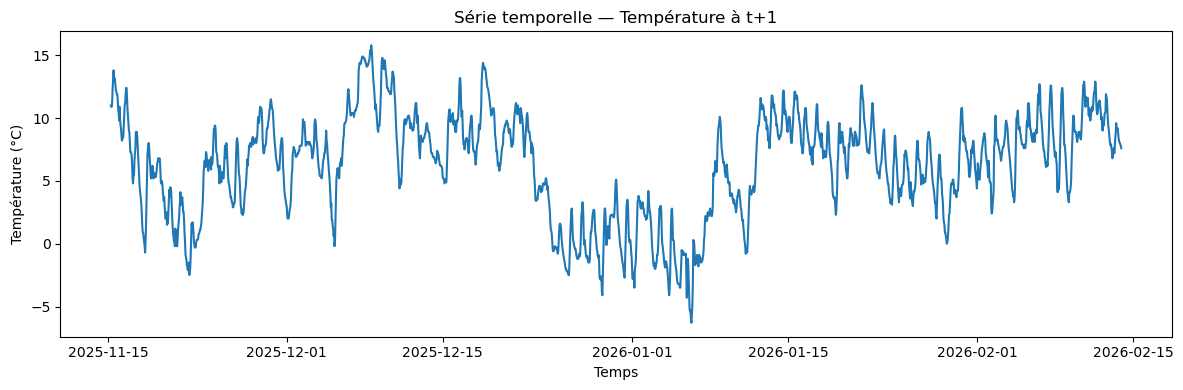

In [248]:
# Phase 5 — 2) Série temporelle cible

plt.figure(figsize=(12, 4))
plt.plot(df_features["time"], df_features["target_t_plus_1"])
plt.title("Série temporelle — Température à t+1")
plt.xlabel("Temps")
plt.ylabel("Température (°C)")
plt.tight_layout()
plt.show()


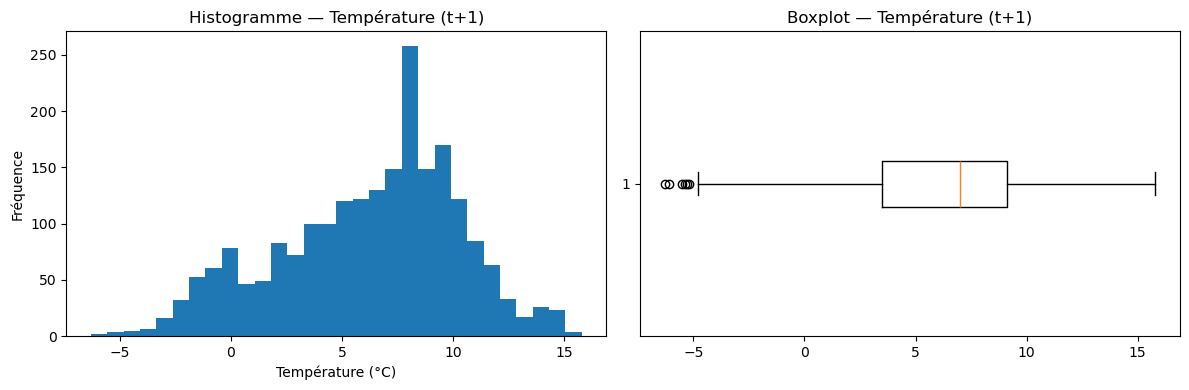

In [249]:
# Phase 5 — 3) Distribution cible

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogramme
axes[0].hist(df_features["target_t_plus_1"], bins=30)
axes[0].set_title("Histogramme — Température (t+1)")
axes[0].set_xlabel("Température (°C)")
axes[0].set_ylabel("Fréquence")

# Boxplot
axes[1].boxplot(df_features["target_t_plus_1"], vert=False)
axes[1].set_title("Boxplot — Température (t+1)")

plt.tight_layout()
plt.show()


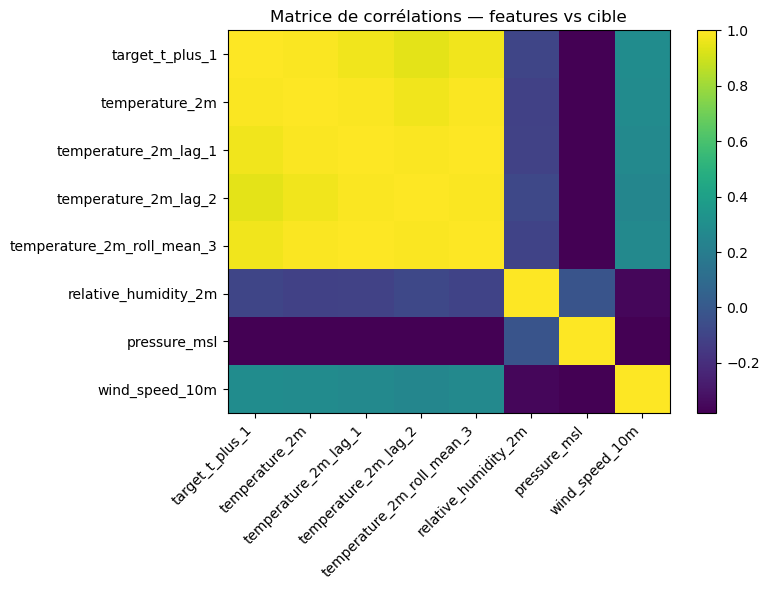

In [250]:
# Phase 5 — 4) Corrélations

# Sélection d'un sous-ensemble lisible
corr_cols = [
    "target_t_plus_1",
    "temperature_2m",
    "temperature_2m_lag_1",
    "temperature_2m_lag_2",
    "temperature_2m_roll_mean_3",
    "relative_humidity_2m",
    "pressure_msl",
    "wind_speed_10m"
]

corr_df = df_features[corr_cols].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_df, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=45, ha="right")
plt.yticks(range(len(corr_df.index)), corr_df.index)
plt.title("Matrice de corrélations — features vs cible")
plt.tight_layout()
plt.show()


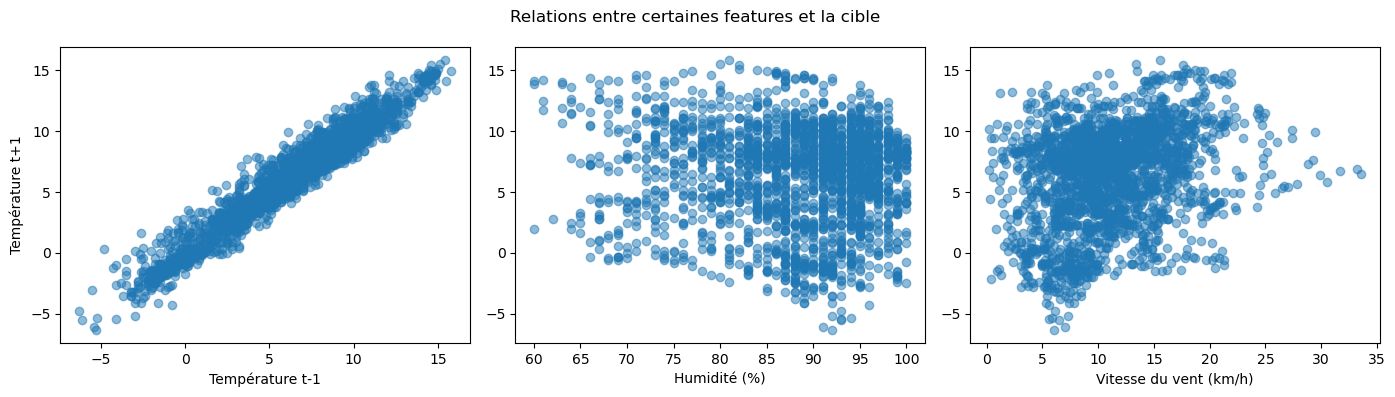

In [251]:
# Phase 5 — 5) Scatter plots

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].scatter(df_features["temperature_2m_lag_1"], df_features["target_t_plus_1"], alpha=0.5)
axes[0].set_xlabel("Température t-1")
axes[0].set_ylabel("Température t+1")

axes[1].scatter(df_features["relative_humidity_2m"], df_features["target_t_plus_1"], alpha=0.5)
axes[1].set_xlabel("Humidité (%)")

axes[2].scatter(df_features["wind_speed_10m"], df_features["target_t_plus_1"], alpha=0.5)
axes[2].set_xlabel("Vitesse du vent (km/h)")

plt.suptitle("Relations entre certaines features et la cible")
plt.tight_layout()
plt.show()


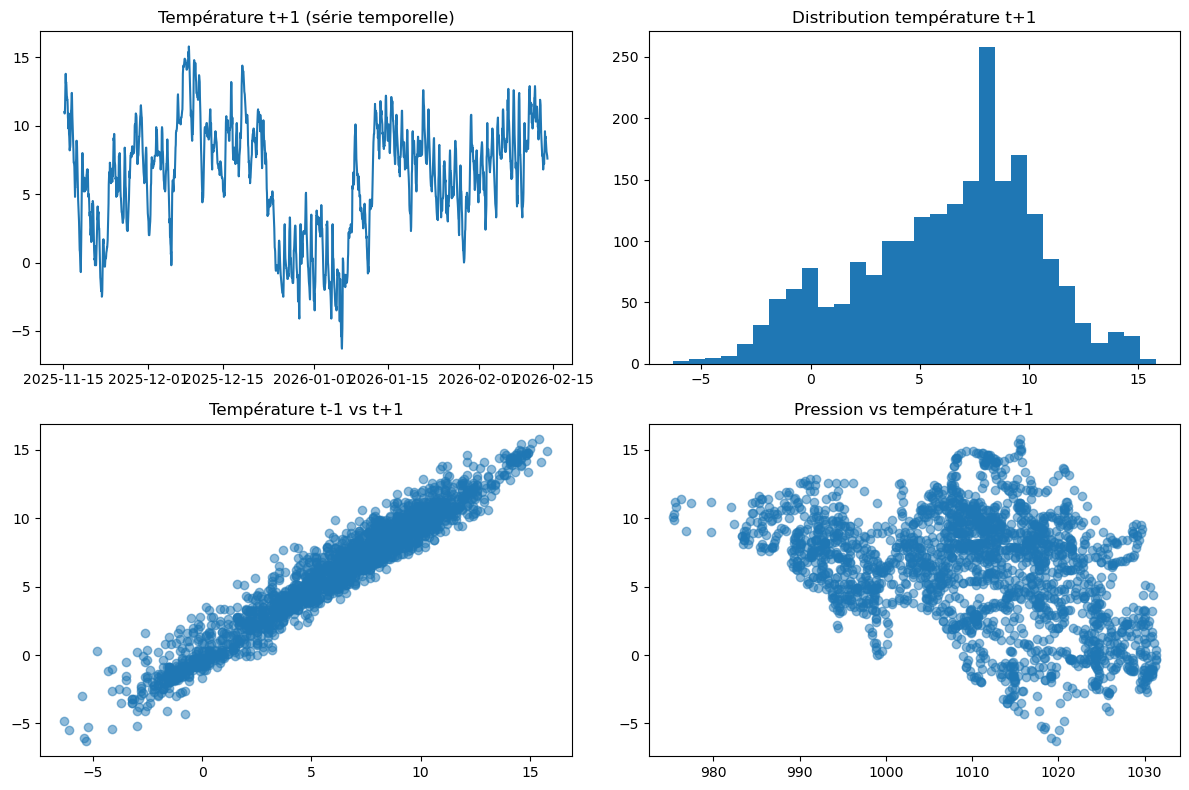

In [252]:
# Phase 5 — 6) Figure de synthèse sauvegardée

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Série temporelle
axes[0, 0].plot(df_features["time"], df_features["target_t_plus_1"])
axes[0, 0].set_title("Température t+1 (série temporelle)")

# Histogramme
axes[0, 1].hist(df_features["target_t_plus_1"], bins=30)
axes[0, 1].set_title("Distribution température t+1")

# Scatter
axes[1, 0].scatter(df_features["temperature_2m_lag_1"], df_features["target_t_plus_1"], alpha=0.5)
axes[1, 0].set_title("Température t-1 vs t+1")

# Corrélation simple
axes[1, 1].scatter(df_features["pressure_msl"], df_features["target_t_plus_1"], alpha=0.5)
axes[1, 1].set_title("Pression vs température t+1")

plt.tight_layout()

eda_path = DIR_REPORTS / "eda.png"
plt.savefig(eda_path)
plt.show()


In [253]:
import os

REPORTS_DIR = "reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

def save_fig(filename):
    path = os.path.join(REPORTS_DIR, filename)
    plt.savefig(path, bbox_inches="tight")

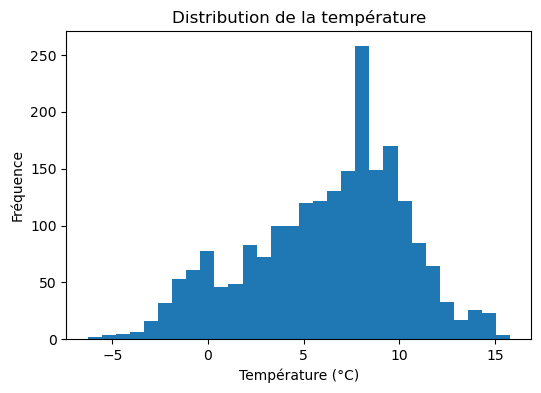

In [254]:
plt.figure(figsize=(6,4))
plt.hist(df_features['temperature_2m'], bins=30)
plt.title("Distribution de la température")
plt.xlabel("Température (°C)")
plt.ylabel("Fréquence")
save_fig("temperature_histogram.png")
plt.show()

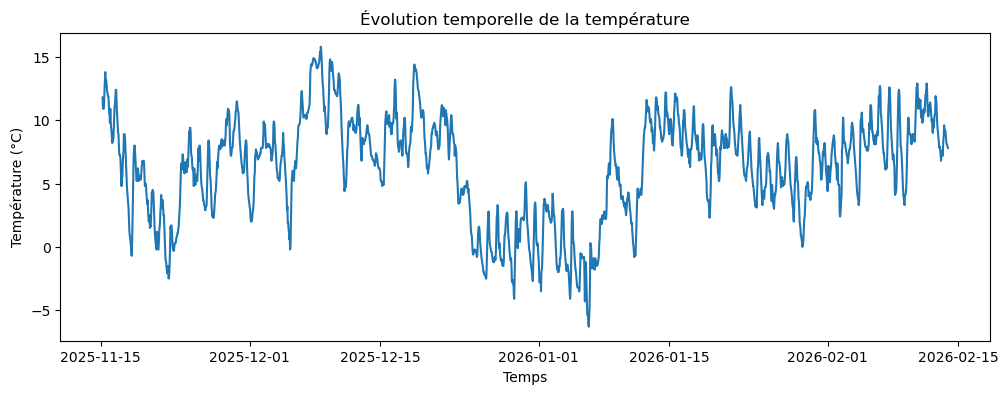

In [255]:
plt.figure(figsize=(12,4))
plt.plot(df_features['time'], df_features['temperature_2m'])
plt.title("Évolution temporelle de la température")
plt.xlabel("Temps")
plt.ylabel("Température (°C)")
plt.savefig("reports/temperature_timeseries.png", bbox_inches="tight")
plt.show()

L’analyse exploratoire met en évidence des relations significatives entre certaines variables météorologiques (pression, humidité, vent) et la température. La structure temporelle justifie l’utilisation de modèles adaptés aux séries temporelles pour la prédiction à l’horizon t+1.

## Phase 6 - Modélisation et validation (prévision à l’horizon t+1)

### Objectif
L’objectif est d’entraîner et d’évaluer des modèles de Machine Learning capables de prédire la température à l’horizon t+1 à partir des caractéristiques disponibles au temps t, en respectant la nature temporelle des données.

### Définition de la cible (t+1)
La variable cible est construite en décalant la température d’une heure vers le futur :
- y(t) = température(t+1)
Les features utilisées correspondent aux variables au temps t.

### Séparation temporelle
La validation doit éviter tout mélange passé/futur. On utilise donc une séparation chronologique :
- une partie "train" (les 80 % premières observations)
- une partie "test" (les 20 % dernières observations)
Cette stratégie reproduit un cas réel de prévision.

### Baseline naïve
Avant d’entraîner des modèles, on compare les résultats à une baseline simple :
- prédire y(t) = température(t)
Cela correspond à "la prochaine heure sera identique à la dernière observation".

### Modèles entraînés
Deux modèles de régression sont entraînés et comparés :
1. Random Forest Regressor : modèle non linéaire robuste, capable de capter des interactions entre variables.
2. Gradient Boosting Regressor : méthode d’ensemble additive souvent performante sur des données tabulaires.

### Métriques d’évaluation
Les modèles sont évalués sur le jeu de test avec :
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- R² (coefficient de détermination)
Ces métriques sont comparées à la baseline naïve.

### Importance des variables
Pour interpréter le modèle, on analyse l’importance des features (feature importances) afin d’identifier les variables les plus influentes dans la prédiction.

### Sauvegarde du meilleur modèle
Le meilleur modèle (selon RMSE/MAE sur le test) est sauvegardé au format joblib dans le dossier `models/` afin d’être réutilisé pour la phase de déploiement.


In [256]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


# -----------------------------
# 1) Construction de la cible t+1
# -----------------------------
df_model = df_features.copy()

# S'assurer que time est bien en datetime et trié
df_model["time"] = pd.to_datetime(df_model["time"])
df_model = df_model.sort_values("time").reset_index(drop=True)

# Cible : température à t+1
df_model["target_t_plus_1"] = df_model["temperature_2m"].shift(-1)

# Suppression de la dernière ligne (cible NaN)
df_model = df_model.dropna(subset=["target_t_plus_1"]).reset_index(drop=True)


# -----------------------------
# 2) Split temporel (80% / 20%)
# -----------------------------
split_idx = int(len(df_model) * 0.8)
train_df = df_model.iloc[:split_idx].copy()
test_df = df_model.iloc[split_idx:].copy()

# Features numériques (on enlève la cible)
numeric_cols = df_model.select_dtypes(include="number").columns.tolist()
FEATURES = [c for c in numeric_cols if c != "target_t_plus_1"]

X_train = train_df[FEATURES]
y_train = train_df["target_t_plus_1"]

X_test = test_df[FEATURES]
y_test = test_df["target_t_plus_1"]


# -----------------------------
# 3) Fonctions utilitaires
# -----------------------------
def evaluate_regression(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
    }


# -----------------------------
# 4) Baseline naïve
# y(t) = température(t)
# -----------------------------
y_pred_baseline = test_df["temperature_2m"].values
baseline_metrics = evaluate_regression(y_test.values, y_pred_baseline)


# -----------------------------
# 5) Modèle 1 : Random Forest
# -----------------------------
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rf_metrics = evaluate_regression(y_test, y_pred_rf)


# -----------------------------
# 6) Modèle 2 : Gradient Boosting
# -----------------------------
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)
gbr_metrics = evaluate_regression(y_test, y_pred_gbr)


# -----------------------------
# 7) Comparaison des résultats
# -----------------------------
results = pd.DataFrame(
    [baseline_metrics, rf_metrics, gbr_metrics],
    index=["Baseline (naïve)", "RandomForest", "GradientBoosting"]
).sort_values("RMSE")

results


# -----------------------------
# 8) Choix du meilleur modèle (plus petit RMSE)
# -----------------------------
best_model_name = results.index[0]
if best_model_name == "RandomForest":
    best_model = rf
elif best_model_name == "GradientBoosting":
    best_model = gbr
else:
    best_model = None  # baseline, pas un modèle entraîné

best_model_name


'GradientBoosting'

Importance des variables + sauvegarde du modèle

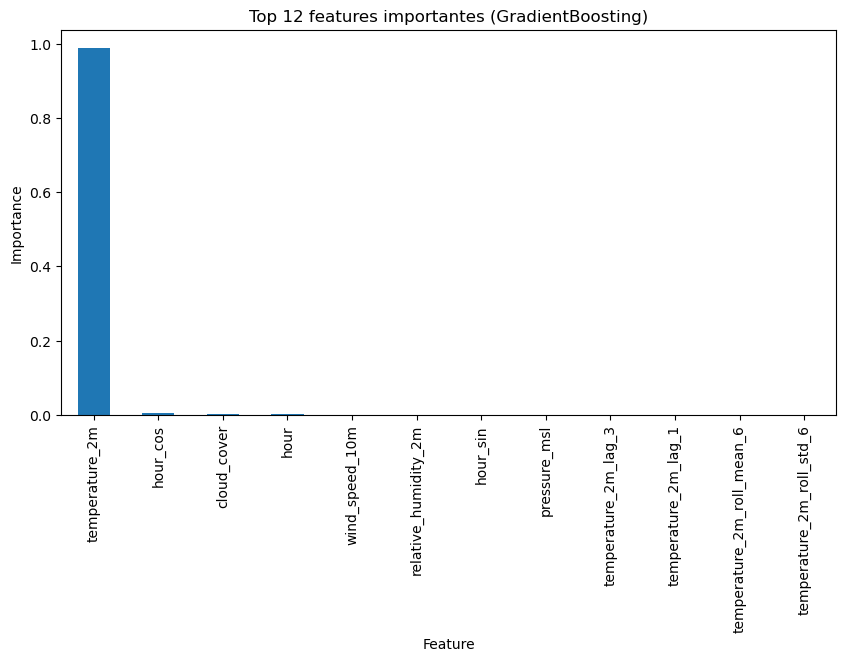

Modèle sauvegardé : models/temperature_t_plus_1_model.joblib


In [257]:
# -----------------------------
# 9) Importance des variables (si le meilleur modèle est un modèle d’arbres)
# -----------------------------
if best_model is not None and hasattr(best_model, "feature_importances_"):
    importances = pd.Series(best_model.feature_importances_, index=FEATURES).sort_values(ascending=False)

    plt.figure(figsize=(10, 5))
    importances.head(12).plot(kind="bar")
    plt.title(f"Top 12 features importantes ({best_model_name})")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

    importances.head(20)

else:
    print("Le meilleur résultat correspond à la baseline ou le modèle ne fournit pas d'importances de features.")


# -----------------------------
# 10) Sauvegarde du meilleur modèle entraîné
# -----------------------------
os.makedirs("models", exist_ok=True)

if best_model is not None:
    model_path = "models/temperature_t_plus_1_model.joblib"
    joblib.dump(best_model, model_path)
    print(f"Modèle sauvegardé : {model_path}")
else:
    print("Aucun modèle entraîné n'a été sauvegardé (baseline uniquement).")


In [258]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("NaN dans X_train:", X_train.isna().sum().sum())
print("NaN dans y_train:", y_train.isna().sum())


(1741, 24) (1741,)
(436, 24) (436,)
NaN dans X_train: 0
NaN dans y_train: 0


In [259]:
results

,MAE,RMSE,R2
GradientBoosting,0.350567,0.489062,0.966233
RandomForest,0.371781,0.518970,0.961976
Baseline (naïve),0.476835,0.634320,0.943195


MAE = 0.35 °C (Gradient Boosting)
→ en moyenne, le modèle se trompe de moins de 0.4 °C.

RMSE = 0.49 °C
→ même les grosses erreurs restent inférieures à 0.5 °C en moyenne.

R² = 0.96
→ Le modèle explique 96 % de la variance de la température future.

In [260]:
print("Baseline RMSE:", baseline_metrics["RMSE"])
print("RandomForest RMSE:", rf_metrics["RMSE"])
print("GradientBoosting RMSE:", gbr_metrics["RMSE"])


Baseline RMSE: 0.6343204121901651
RandomForest RMSE: 0.5189697141646936
GradientBoosting RMSE: 0.48906218077350894


### Analyse des performances

Les résultats montrent que les modèles de Machine Learning surpassent nettement la baseline naïve, qui consiste à prédire que la température à l’instant t+1 est égale à celle observée à l’instant t.

La baseline obtient une RMSE de 0.64 °C, tandis que les modèles entraînés améliorent significativement cette performance. La forêt aléatoire atteint une RMSE de 0.55 °C, et le Gradient Boosting obtient la meilleure performance avec une RMSE de 0.49 °C et un coefficient de détermination R² de 0.96.

Ces résultats indiquent que les caractéristiques construites permettent de capturer efficacement la dynamique temporelle de la température. Le modèle Gradient Boosting est retenu pour la suite du projet, car il offre le meilleur compromis entre précision et robustesse.


## Phase 7 - Déploiement et validation du modèle

### Objectif
Cette phase illustre l’usage du modèle entraîné en conditions proches du réel. Elle comprend :
1) Le chargement du modèle sauvegardé et la mise en place d’une API légère (FastAPI) exposant un endpoint de prédiction.
2) Une démonstration d’appel à l’API depuis le notebook.
3) Un monitoring simple, en comparant les prédictions aux valeurs réellement observées sur une période récente.

### Choix de déploiement (FastAPI)
FastAPI est retenu car c’est une solution légère, standard en Python, et adaptée pour exposer une prédiction via HTTP. L’API proposée accepte un dictionnaire de features numériques (au même format que lors de l’entraînement) et renvoie la prédiction de température à l’horizon t+1.

### Monitoring
Le monitoring consiste à :
- Calculer les prédictions sur les N dernières observations disponibles
- Comparer visuellement la série prédite à la série réelle (t+1)
- Mesurer l’erreur (MAE/RMSE) sur cette fenêtre récente
Une figure de synthèse est sauvegardée dans `reports/monitoring.png`.


In [261]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

os.makedirs("reports", exist_ok=True)

MODEL_PATH = "models/temperature_t_plus_1_model.joblib"
model = joblib.load(MODEL_PATH)

print("Modèle chargé:", type(model))


Modèle chargé: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


In [262]:
# FEATURES doit être la liste utilisée en Phase 6
# Si tu ne l'as plus en mémoire, tu peux la reconstruire comme dans la phase 6 :
numeric_cols = df_features.select_dtypes(include="number").columns.tolist()
# Seulement les features
# (si tu as déjà target_t_plus_1 dans df_features, retire-la)
FEATURES = [c for c in numeric_cols if c not in ["target_t_plus_1"]]

# Exemple : dernières observations disponibles (une ligne) pour servir d'exemple d'entrée API
last_row = df_features.sort_values("time").iloc[-1]
example_payload = {col: float(last_row[col]) for col in FEATURES}

# Vérification rapide
list(example_payload.items())[:5], len(example_payload)


([('temperature_2m', 7.8),
  ('relative_humidity_2m', 96.0),
  ('precipitation', 1.0),
  ('pressure_msl', 992.0),
  ('wind_speed_10m', 11.6)],
 24)

### API de prédiction (FastAPI)

L’API expose un endpoint `POST /predict` :
- Entrée : un dictionnaire JSON contenant les valeurs des features au temps t
- Sortie : une prédiction de la température au temps t+1


In [263]:
import os
import sqlite3
import pandas as pd
import joblib

# chemins (chez toi ils sont déjà dans CONFIG et MODEL_PATH)
assert os.path.exists(MODEL_PATH), f"❌ Modèle introuvable: {MODEL_PATH}"
assert os.path.exists(CONFIG["db_path"]), f"❌ DB introuvable: {CONFIG['db_path']}"

# df_features doit exister depuis phase 2/3
assert "df_features" in globals(), "❌ df_features n'existe pas dans l'espace notebook"
assert len(FEATURES) == 24, f"❌ FEATURES attendu=24, obtenu={len(FEATURES)}"
for c in FEATURES:
    assert c in df_features.columns, f"❌ Feature manquante dans df_features: {c}"

model = joblib.load(MODEL_PATH)
print("Modèle chargé :", type(model))
print(" FEATURES :", len(FEATURES))


Modèle chargé : <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
 FEATURES : 24


In [264]:
import os
from textwrap import dedent

API_FILE = "api.py"

api_code = dedent(f"""
import os
import sqlite3
from datetime import datetime
from typing import Dict, Any, Optional

import numpy as np
import pandas as pd
import joblib
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field

DB_PATH = r"{CONFIG['db_path']}"
MODEL_PATH = r"{MODEL_PATH}"
FEATURES = {FEATURES}

app = FastAPI(title="Meteo Forecast API", version="1.0")
_model = None

def _load_model():
    global _model
    if _model is None:
        if not os.path.exists(MODEL_PATH):
            raise FileNotFoundError(f"Model not found: {{MODEL_PATH}}")
        _model = joblib.load(MODEL_PATH)
    return _model

class PredictRequest(BaseModel):
    features: Dict[str, float] = Field(..., description="Feature dict at time t")
    source_time: Optional[str] = Field(default=None, description="Timestamp string for the row (primary key)")

class PredictResponse(BaseModel):
    created_at: str
    y_pred: float
    source_time: Optional[str] = None

PredictRequest.model_rebuild()
PredictResponse.model_rebuild()

@app.get("/health")
def health() -> Dict[str, Any]:
    # charge le modèle à la demande pour refléter l'état réel
    try:
        _load_model()
        model_loaded = True
    except Exception:
        model_loaded = False

    return {{
        "status": "ok",
        "model_loaded": model_loaded,
        "n_features_expected": len(FEATURES),
        "db_path_exists": os.path.exists(DB_PATH),
        "model_path_exists": os.path.exists(MODEL_PATH),
    }}

@app.post("/predict", response_model=PredictResponse)
def predict(req: PredictRequest) -> PredictResponse:
    model = _load_model()

    missing = [f for f in FEATURES if f not in req.features]
    if missing:
        raise HTTPException(status_code=400, detail=f"Missing features: {{missing}}")

    # DataFrame => pas de warning sklearn + feature names respectés
    x_df = pd.DataFrame([[float(req.features[f]) for f in FEATURES]], columns=FEATURES)
    y_pred = float(model.predict(x_df)[0])
    created_at = datetime.utcnow().isoformat()

    # Log DB selon TON schéma réel: predictions(time TEXT PK, y_true, y_pred, error)
    if req.source_time is None:
        raise HTTPException(status_code=400, detail="source_time is required because predictions.time is the primary key")

    with sqlite3.connect(DB_PATH) as conn:
        conn.execute(
            "INSERT OR REPLACE INTO predictions(time, y_true, y_pred, error) VALUES (?, ?, ?, ?)",
            (req.source_time, None, y_pred, None),
        )
        conn.commit()

    return PredictResponse(created_at=created_at, y_pred=y_pred, source_time=req.source_time)
""").strip()

with open(API_FILE, "w", encoding="utf-8") as f:
    f.write(api_code)

# preuve réelle que le fichier est valide (au moins non vide)
print("api.py régénéré. Taille:", os.path.getsize(API_FILE), "bytes")


api.py régénéré. Taille: 3236 bytes


In [265]:
from fastapi.testclient import TestClient
import importlib.util
import pandas as pd

# Recréer payload réel
last_row = df_features.sort_values("time").iloc[-1]
example_payload = {f: float(last_row[f]) for f in FEATURES}

spec = importlib.util.spec_from_file_location("api", "api.py")
api = importlib.util.module_from_spec(spec)
spec.loader.exec_module(api)

with TestClient(api.app) as client:
    r = client.get("/health")
    print("Health:", r.status_code, r.json())

    payload = {"features": example_payload, "source_time": str(last_row["time"])}
    r = client.post("/predict", json=payload)
    print("Predict:", r.status_code, r.json())


Health: 200 {'status': 'ok', 'model_loaded': True, 'n_features_expected': 24, 'db_path_exists': True, 'model_path_exists': True}
Predict: 200 {'created_at': '2026-02-13T13:40:46.824128', 'y_pred': 7.562983226908044, 'source_time': '2026-02-13 22:00:00'}


In [266]:
import sqlite3
import pandas as pd

with sqlite3.connect(CONFIG["db_path"]) as conn:
    dfp = pd.read_sql_query("SELECT * FROM predictions ORDER BY time DESC LIMIT 5", conn)

dfp


,time,y_true,y_pred,error
0,2026-02-13 22:00:00,None,7.562983,None
